In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import geopandas as gpd
import rasterio as rio

from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, TimeSeriesSplit

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from copy import deepcopy

# Load Datasets

- Flood Intensity Index `agg_full`
- PRISM Precipitation Parameters
- LCMAP
- Watershed Properties

In [2]:
city_list = ["Oklahoma_City", "Springfield", "Louisville"]
columns_to_keep = ['huc12', 'Datetime', 'Flood_Intensity_Index']

In [3]:
all_dfs = []

for city in city_list:
    # Read each file with city-specific paths
    agg_full = pd.read_csv(
        f'/Users/ywu10/SynologyDrive/Important/Research_Data/USGS_streamflow/{city}/{city}_HUC12_Monthly_FII.csv',
        dtype={'huc12': str},
        usecols=columns_to_keep
    )
    precip = pd.read_csv(
        f'/Users/ywu10/SynologyDrive/Important/Research_Data/Precip/PRISM/{city}/{city}_HUC12_precip_parameters.csv',
        index_col=0,
        dtype={'huc12': str}
    )
    LCMAP_raw = pd.read_csv(
        f'/Users/ywu10/SynologyDrive/Important/Research_Data/AC/{city}/{city}_all_summary.csv',
        dtype={'huc12': str}
    )
    lcmap = LCMAP_raw.loc[LCMAP_raw.index.repeat(12)].copy()
    lcmap['month'] = np.tile([f'{i:02d}' for i in range(1, 13)], len(LCMAP_raw))
    lcmap['Datetime'] = lcmap['Datetime'].astype(str) + '-' + lcmap['month']
    lcmap.drop(columns=['month','Ice or Snow_pct', 'Ice or Snow_pct_netchange'], axis=1, inplace=True)
    watershed_properties = pd.read_csv(
        f"/Users/ywu10/SynologyDrive/Important/Watershed_properties/{city}/{city}_watershed_properties.csv",
        dtype={'huc12': str}
    )
    # Merge files as per your workflow
    df = agg_full.merge(precip, on=['huc12', 'Datetime'], how='left')
    df = df.merge(lcmap, on=['huc12', 'Datetime'], how='left')
    df = df.merge(watershed_properties, on='huc12', how='left')
    df = df[~df['Datetime'].between('1996-01', '1996-12')]
    # Add city column
    df['city'] = city
    all_dfs.append(df)

# Concatenate all city dataframes into one
final_df = pd.concat(all_dfs, ignore_index=True)

In [4]:
final_df

,huc12,Datetime,Flood_Intensity_Index,prcp_sum,prcp_max_1day,prcp_wet_days,prcp_heavy_days_p90,prcp_heavy_days_p95,prcp_antecedent1mo,prcp_antecedent2mo,...,plan_pct_neg,flow_mean,flow_95pct,flow_pct_high,hand_surface,hand_shallow,hand_deep,twi_median,twi_90pct,city
0,110500020801,1997-01,-0.499554,7.178000,4.221333,2.0,0.0,0.0,2.764333,99.386168,...,42.964128,886.9639,147.0,7.908314,86.528854,13.436506,0.034640,8.811801,11.399548,Oklahoma_City
1,110500020801,1997-02,-0.499252,84.120502,39.520668,8.0,1.0,1.0,7.178000,2.764333,...,42.964128,886.9639,147.0,7.908314,86.528854,13.436506,0.034640,8.811801,11.399548,Oklahoma_City
2,110500020801,1997-03,-0.499554,9.024167,4.533333,2.0,0.0,0.0,84.120502,7.178000,...,42.964128,886.9639,147.0,7.908314,86.528854,13.436506,0.034640,8.811801,11.399548,Oklahoma_City
3,110500020801,1997-04,-0.047197,145.109165,37.657997,14.0,1.0,1.0,9.024167,84.120502,...,42.964128,886.9639,147.0,7.908314,86.528854,13.436506,0.034640,8.811801,11.399548,Oklahoma_City
4,110500020801,1997-05,-0.030747,91.396167,19.689833,11.0,0.0,0.0,145.109165,9.024167,...,42.964128,886.9639,147.0,7.908314,86.528854,13.436506,0.034640,8.811801,11.399548,Oklahoma_City
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22195,051401021205,2021-08,-0.446229,154.912693,47.241898,11.0,3.0,2.0,132.615698,92.742797,...,47.848485,2884.1946,12.0,2.745595,54.376930,16.731129,28.891941,7.639765,10.340151,Louisville
22196,051401021205,2021-09,0.254474,218.420396,56.955200,9.0,4.0,2.0,154.912693,132.615698,...,47.848485,2884.1946,12.0,2.745595,54.376930,16.731129,28.891941,7.639765,10.340151,Louisville
22197,051401021205,2021-10,-0.341289,104.948298,34.388401,11.0,1.0,1.0,218.420396,154.912693,...,47.848485,2884.1946,12.0,2.745595,54.376930,16.731129,28.891941,7.639765,10.340151,Louisville
22198,051401021205,2021-11,-0.505433,46.879999,11.676200,7.0,0.0,0.0,104.948298,218.420396,...,47.848485,2884.1946,12.0,2.745595,54.376930,16.731129,28.891941,7.639765,10.340151,Louisville


# Multicollinearity Analysis

- Variance Inflation Factor (VIF) is the typical diagnostic.
- A VIF > 5 (sometimes > 10) indicates problematic collinearity.
- Check and visualize VIF to flag/remove multicollinear predictors.

In [5]:
features = [col for col in final_df.columns if col not in ['huc12', 'Datetime', 'Flood_Intensity_Index', 'city', 'hand_shallow', 'hand_surface', 
                                                           'twi_median', 'twi_90pct', 'plan_pct_neg', 'plan_mean', 'plan_std','prof_pct_neg', 'prof_std', 
                                                          'asp_var', 'slope_cv', 'slope_above_90th_mean', 'ele_hi', 'prcp_sum', 'ele_below_10th_mean',
                                                          'ele_std', 'Tree Cover_pct', 'flow_95pct', 'flow_pct_high', 'prcp_heavy_days_p90']]
X = final_df[features].select_dtypes(include=[np.number]).dropna()  # works best on complete cases

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data.sort_values('VIF', ascending=False))

                         feature       VIF
18         slope_below_10th_mean  7.968158
19                      asp_mean  7.821700
1                  prcp_wet_days  7.112864
0                  prcp_max_1day  6.577631
23                     hand_deep  5.953268
5                  Developed_pct  4.245564
7                   Cropland_pct  3.658114
3             prcp_antecedent1mo  3.423779
4             prcp_antecedent2mo  3.342526
2            prcp_heavy_days_p95  3.183939
21                     prof_mean  2.869741
9             Grass or Shrub_pct  2.671180
12                     Water_pct  2.349527
22                     flow_mean  2.232504
14                   Wetland_pct  1.804296
16                    Barren_pct  1.552897
8         Cropland_pct_netchange  1.482467
10  Grass or Shrub_pct_netchange  1.348371
6        Developed_pct_netchange  1.329892
11      Tree Cover_pct_netchange  1.237856
20                       asp_pc1  1.200020
17          Barren_pct_netchange  1.095728
13         

In [6]:
# corr = X.corr()
# high_corrs = corr['prcp_heavy_days_p90'].abs().sort_values(ascending=False)
# print(high_corrs)

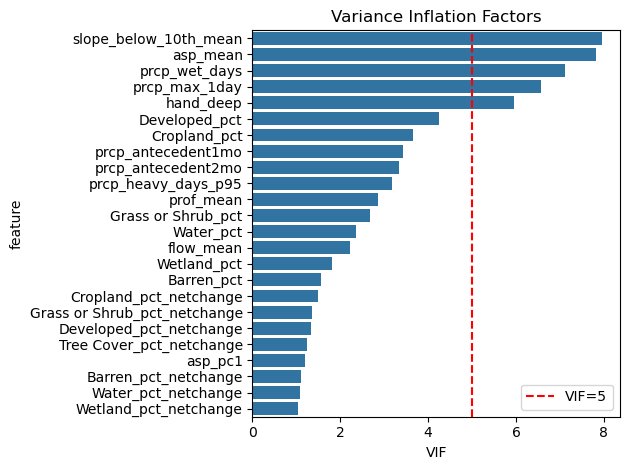

In [7]:
sns.barplot(x="VIF", y="feature", data=vif_data.sort_values('VIF', ascending=False))
plt.axvline(5, color='red', linestyle='--', label='VIF=5')
plt.title("Variance Inflation Factors")
plt.legend()
plt.tight_layout()
plt.show()

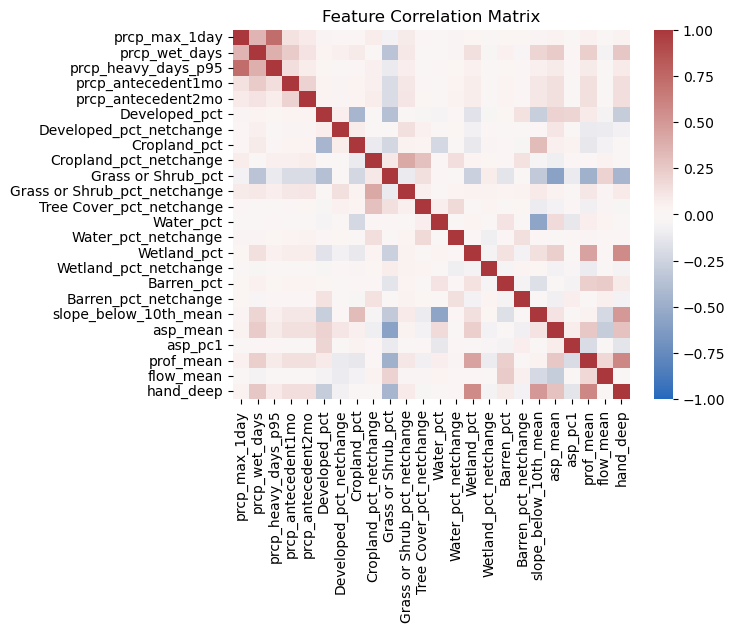

In [8]:
corr = final_df[features].corr()
sns.heatmap(corr, annot=False, cmap="vlag", center=0, vmin=-1, vmax=1)
plt.title('Feature Correlation Matrix')
plt.show()

# Prepare Input Data

## Scaling for the Models

Although Random Forest does not require feature scaling because it’s based on decision-tree splits and is scale-invariant, we need scaling data for Gaussian Process Regression and Neural Networks to acquire meaningful results.

Therefore, we applied a standard preprocessing pipeline (e.g., `StandardScaler`) before fitting any model so the feature input is consistent across model types.

In [9]:
scaler = StandardScaler()
X = df[features]
X_scaled = scaler.fit_transform(X)

# Random Forest

### How does TimeSeriesSplit split the 1997–2021 dataset into 5 blocks?
- Split 1: Train on Months 1–60 (1997–2001), Test on Months 61–90 (2002–2004)
- Split 2: Train on Months 1–90 (1997–2004), Test on Months 91–120 (2005–2007)
- Split 3: Train on Months 1–120 (1997–2007), Test on Months 121–150 (2008–2010)
- Split 4: Train on Months 1–150 (1997–2010), Test on Months 151–180 (2011–2013)
- Split 5: Train on Months 1–180 (1997–2013), Test on Months 181–300 (2014–2021, remainder)

### How well does the model predict "future" flood intensity?
- The model’s skill improves across successive splits (likely because training size increases and patterns stabilize).
- The last split (most recent years as test data) achieves the best R² (0.712)—your model captures recent flood intensity patterns fairly well, using all historical data available.
- Averaging multiple splits gives a robust estimate. Your mean R² is about 0.552—moderate predictive skill for hydrological indices, especially given challenges with stationarity.

In [10]:
# Prepare features and target
X = df[features].values
y = df['Flood_Intensity_Index'].values

tscv = TimeSeriesSplit(n_splits=5)
results = []

for s, (train_idx, test_idx) in enumerate(tscv.split(X)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    rf = RandomForestRegressor(
        n_estimators=150,
        min_samples_leaf=4,
        max_features=0.5,
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train, y_train)

    test_preds = rf.predict(X_test)
    test_r2 = r2_score(y_test, test_preds)
    test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))

    print(f"Split {s+1}: Test R2={test_r2:.3f}, Test RMSE={test_rmse:.3f}")

    results.append({
        'split': s+1,
        'test_r2': test_r2,
        'test_rmse': test_rmse
    })

results_df = pd.DataFrame(results)
mean_test_r2 = results_df['test_r2'].mean()
print(f"Mean Test R2 across splits: {mean_test_r2:.3f}")

Split 1: Test R2=0.468, Test RMSE=0.556
Split 2: Test R2=0.612, Test RMSE=0.535
Split 3: Test R2=0.512, Test RMSE=0.694
Split 4: Test R2=0.560, Test RMSE=0.570
Split 5: Test R2=0.713, Test RMSE=0.369
Mean Test R2 across splits: 0.573


In [11]:
%%time
X = df[features].values
y = df['Flood_Intensity_Index'].values

tscv = TimeSeriesSplit(n_splits=5)
param_grid = {
    'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400],
    'max_depth': [5, 10, 20, None],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', 0.5]
}

grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid,
    cv=tscv,          # Use time series split
    scoring='r2',
    n_jobs=-1)
grid_search.fit(X, y)
print("Best params:", grid_search.best_params_)

/Users/ywu10/anaconda3/envs/geoanalysis/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best params: {'max_depth': None, 'max_features': 0.5, 'min_samples_leaf': 4, 'n_estimators': 150}
CPU times: user 6.98 s, sys: 613 ms, total: 7.59 s
Wall time: 5min 48s


Split 1: Test R2=0.468, Test RMSE=0.556


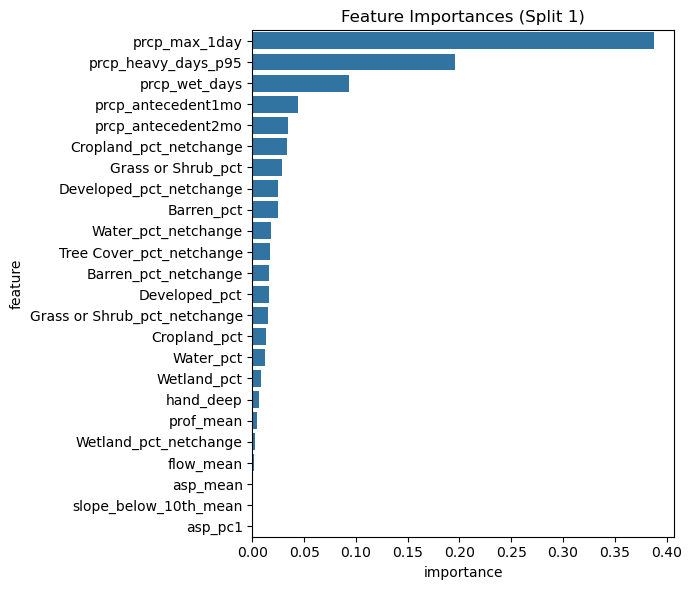

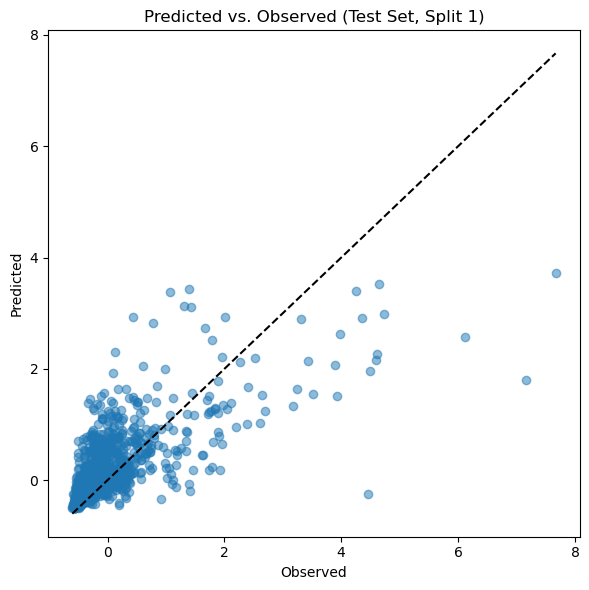

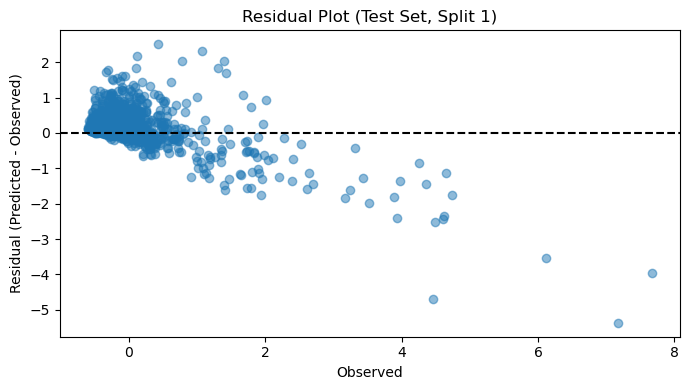

Split 2: Test R2=0.612, Test RMSE=0.535


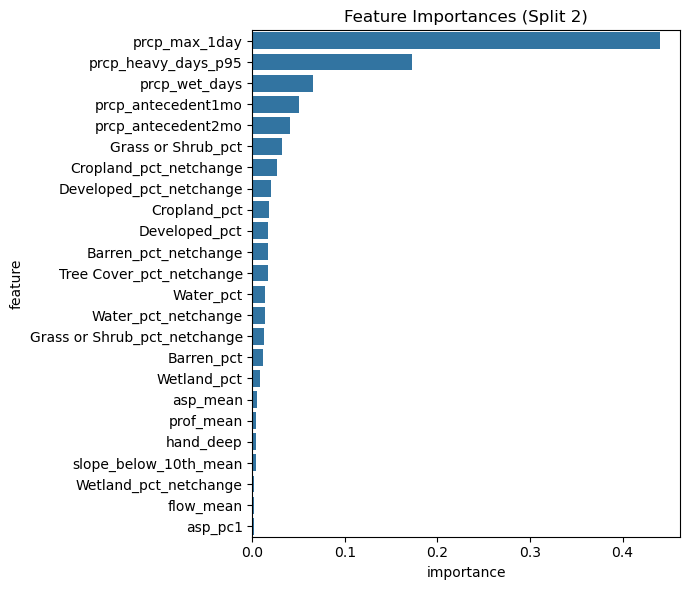

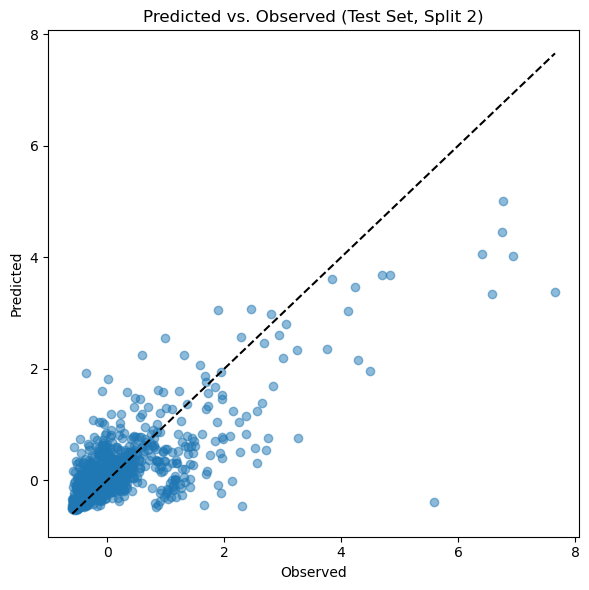

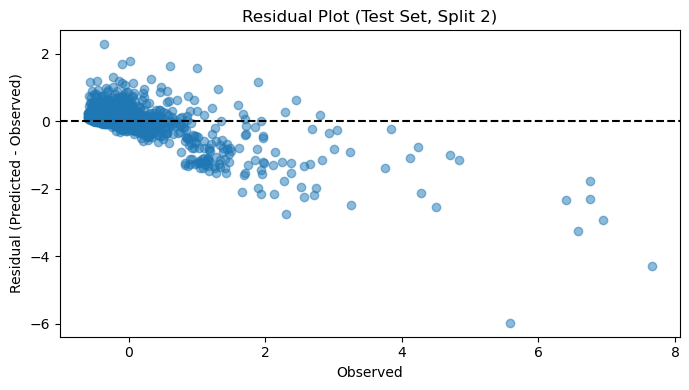

Split 3: Test R2=0.512, Test RMSE=0.694


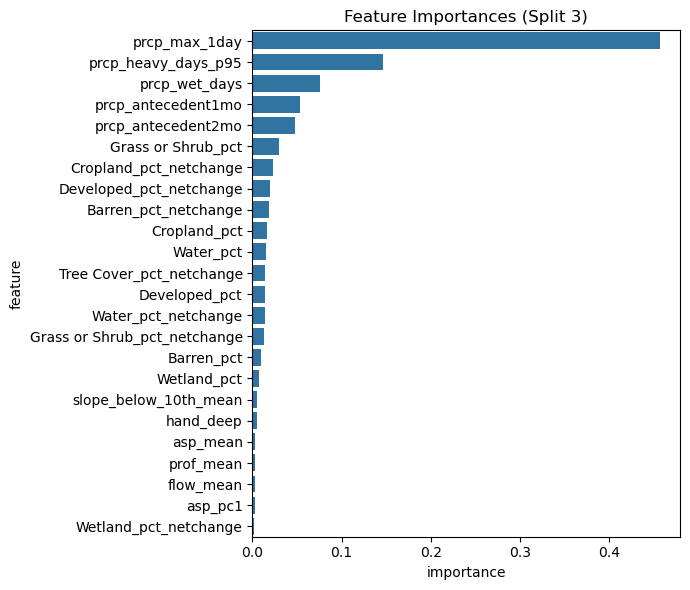

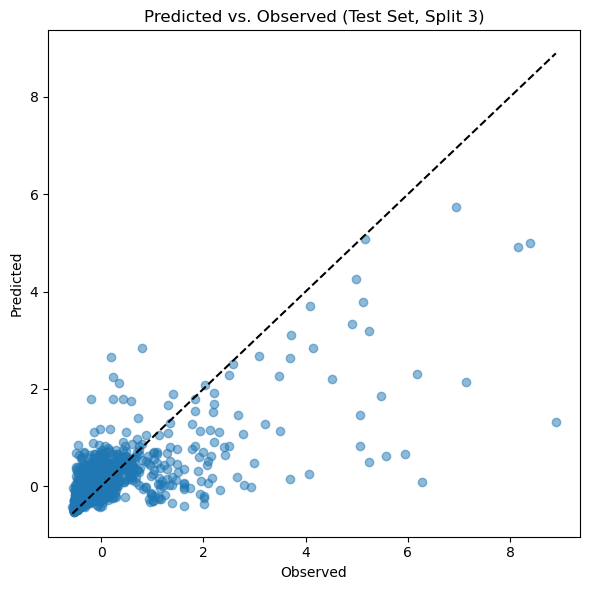

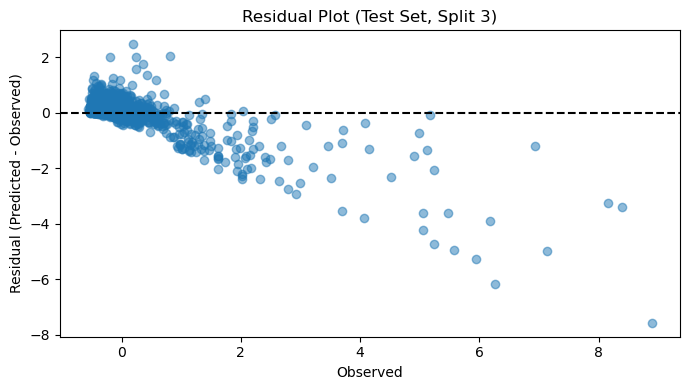

Split 4: Test R2=0.560, Test RMSE=0.570


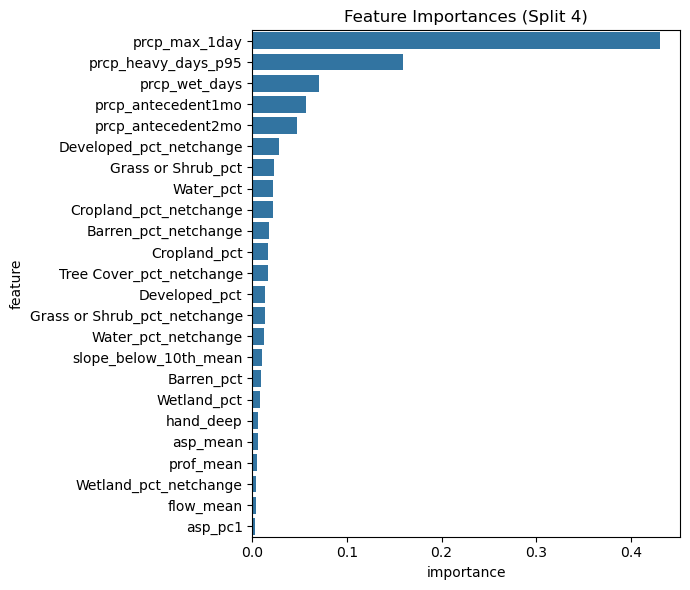

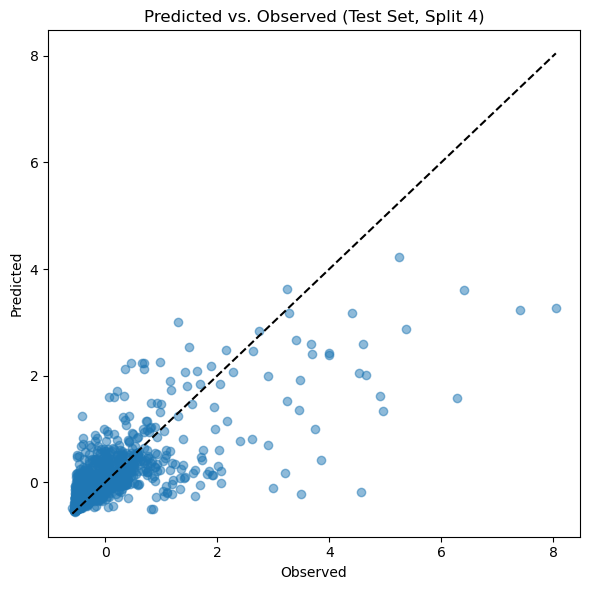

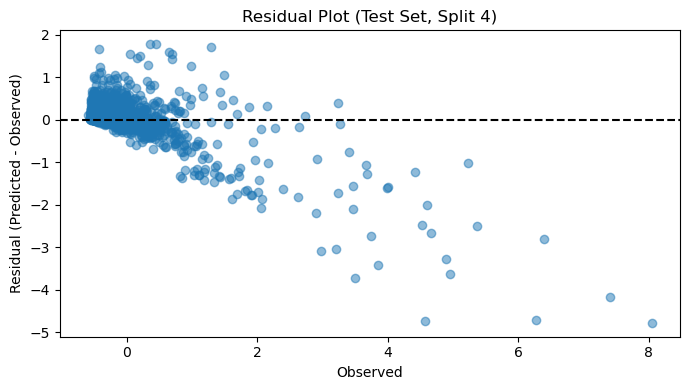

Split 5: Test R2=0.713, Test RMSE=0.369


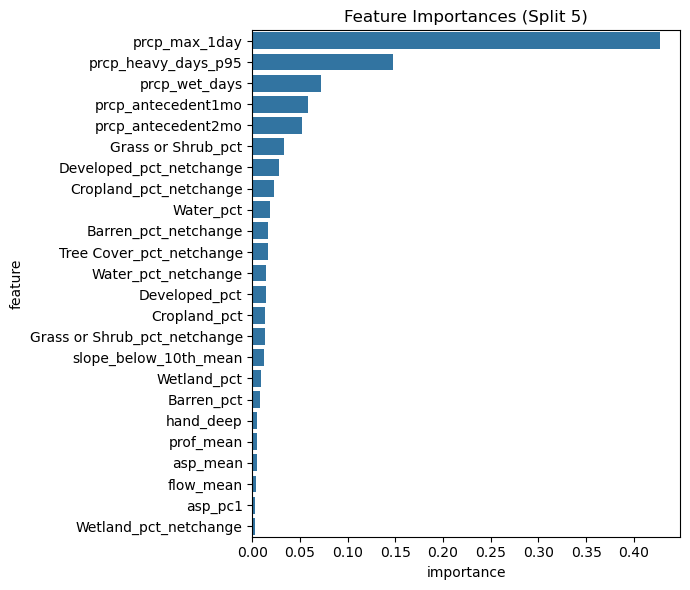

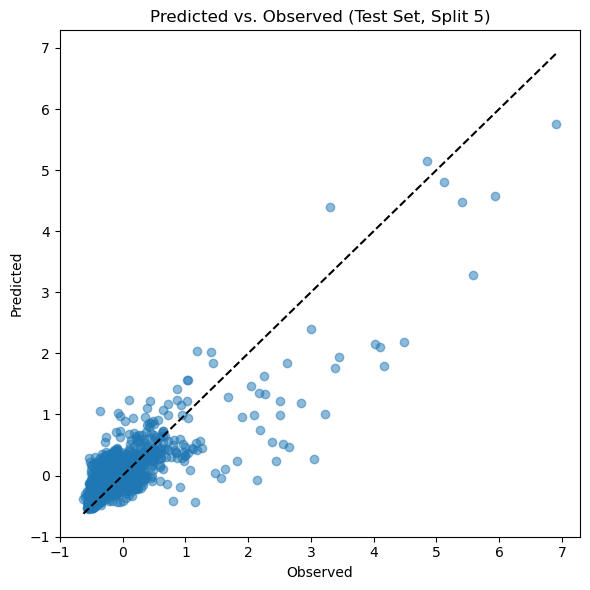

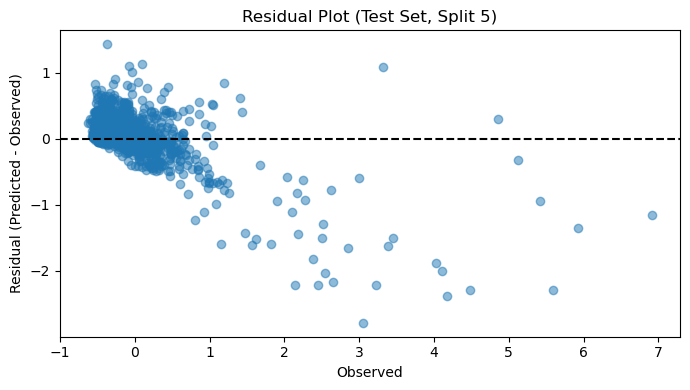

Mean Test R2 across splits: 0.573
CPU times: user 14.1 s, sys: 256 ms, total: 14.3 s
Wall time: 3.42 s


In [12]:
%%time

results = []
for s, (train_idx, test_idx) in enumerate(tscv.split(X)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    rf = RandomForestRegressor(
        n_estimators=grid_search.best_params_['n_estimators'],
        max_depth=grid_search.best_params_['max_depth'],
        min_samples_leaf=grid_search.best_params_['min_samples_leaf'],
        max_features=grid_search.best_params_['max_features'],
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train, y_train)
    test_preds = rf.predict(X_test)
    test_r2 = r2_score(y_test, test_preds)
    test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))
    print(f"Split {s+1}: Test R2={test_r2:.3f}, Test RMSE={test_rmse:.3f}")
    results.append({'split':s+1, 'test_r2':test_r2, 'test_rmse':test_rmse})
    
    # Feature importance
    fi_df = pd.DataFrame({'feature': features, 'importance': rf.feature_importances_}).sort_values('importance', ascending=False)
    plt.figure(figsize=(7,6))
    sns.barplot(x='importance', y='feature', data=fi_df)
    plt.title(f"Feature Importances (Split {s+1})")
    plt.tight_layout()
    plt.show()
    
    # Predicted vs Observed (Test set)
    plt.figure(figsize=(6,6))
    plt.scatter(y_test, test_preds, alpha=0.5)
    plt.xlabel("Observed")
    plt.ylabel("Predicted")
    plt.title(f"Predicted vs. Observed (Test Set, Split {s+1})")
    lims = [y_test.min(), y_test.max()]
    plt.plot(lims, lims, 'k--')
    plt.tight_layout()
    plt.show()
    
    # Residual plot (Test set)
    residuals = test_preds - y_test
    plt.figure(figsize=(7,4))
    plt.scatter(y_test, residuals, alpha=0.5)
    plt.axhline(0, color='k', linestyle='--')
    plt.xlabel("Observed")
    plt.ylabel("Residual (Predicted - Observed)")
    plt.title(f"Residual Plot (Test Set, Split {s+1})")
    plt.tight_layout()
    plt.show()

results_df = pd.DataFrame(results)
mean_test_r2 = results_df['test_r2'].mean()
print(f"Mean Test R2 across splits: {mean_test_r2:.3f}")

### Permutation Importance
Quantifies how much shuffling a feature reduces model accuracy. Less biased than default impurity-based importance in Random Forests.

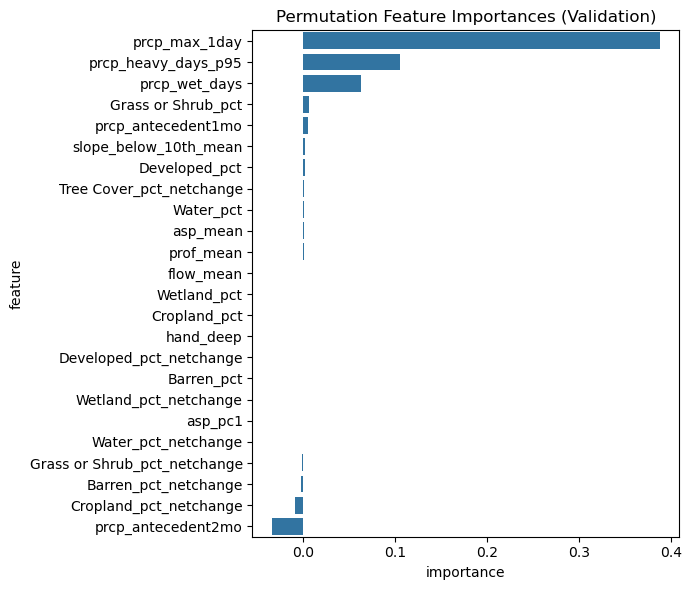

In [17]:
from sklearn.inspection import permutation_importance

# Run permutation importance on the validation set
perm_result = permutation_importance(
    rf, val_df[features], val_df['Flood_Intensity_Index'],
    n_repeats=10, random_state=42, scoring='r2'
)

perm_df = pd.DataFrame({'feature': features, 'importance': perm_result.importances_mean})
perm_df = perm_df.sort_values('importance', ascending=False)

plt.figure(figsize=(7,6))
sns.barplot(x='importance', y='feature', data=perm_df)
plt.title("Permutation Feature Importances (Validation)")
plt.tight_layout()
plt.show()

### Partial Dependence Plots (PDP)
Visualize the average effect of a feature on predictions, marginalizing over the distribution of other features.

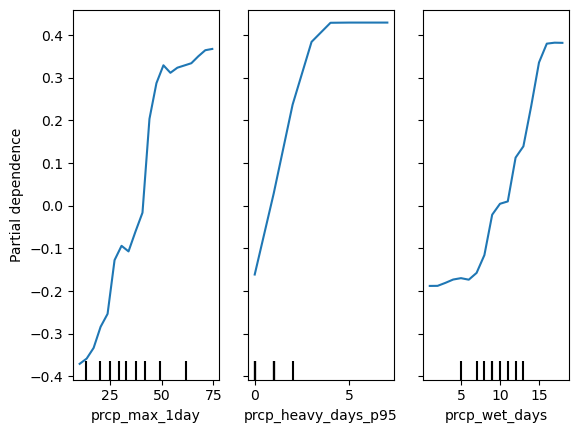

In [18]:
from sklearn.inspection import PartialDependenceDisplay

# One or two top features from importance ranking
top_features = perm_df['feature'].head(3).tolist()

PartialDependenceDisplay.from_estimator(
    rf, val_df[features], top_features,
    kind='average', grid_resolution=20
)
plt.show()

### SHAP (SHapley Additive exPlanations)
Provides feature attributions for individual predictions (global and local explanations).

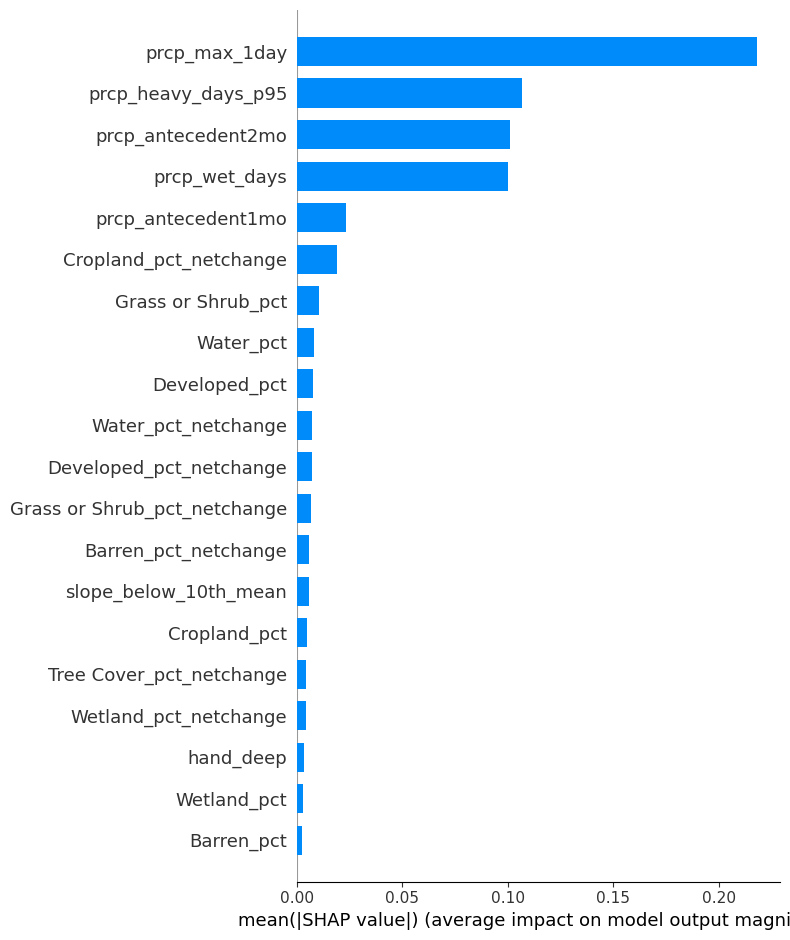

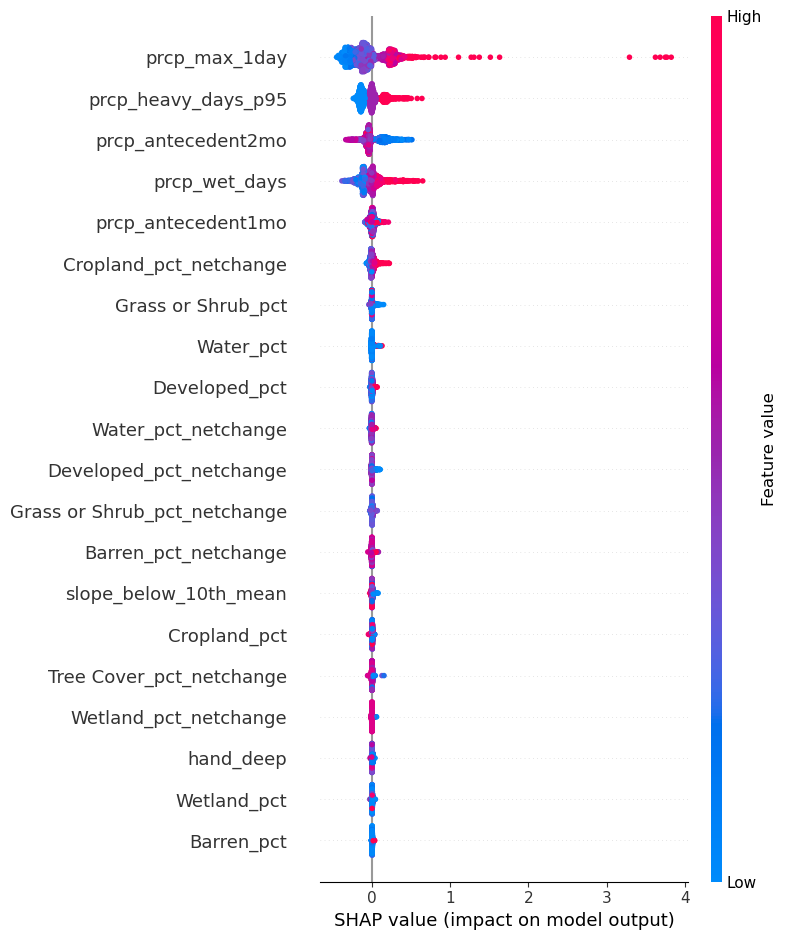

In [19]:
import shap

explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(val_df[features])

# Summary plot (feature importance and effect)
shap.summary_plot(shap_values, val_df[features], plot_type="bar")
# Detailed distribution
shap.summary_plot(shap_values, val_df[features])

# Gaussian Process Regression

In [57]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.preprocessing import StandardScaler

In [61]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
gpr = GaussianProcessRegressor()
scores = cross_val_score(gpr, X_scaled, y, cv=cv, scoring='r2')
print('GPR R2 scores:', scores, 'Mean:', scores.mean())

GPR R2 scores: [0.36594095 0.43494814 0.45967172 0.36371274 0.38092599] Mean: 0.40103990941795475


# Neural Network (DeepEarth/PyTorch)
- Start simple with fully connected layers (MLP).
- Use scaled input.
- Apply early stopping/cross-validation.
- Save code for expansion to multi-site later.

In [13]:
def subset(df, start_ym, end_ym):
    return df[(df['Datetime'] >= start_ym) & (df['Datetime'] <= end_ym)]

# 5 folds: each with train (earlier), val (middle), test (later)
folds = [
    dict(train=("1997-01","2003-12"), val=("2004-01","2007-12"), test=("2008-01","2010-12")),
    dict(train=("1997-01","2005-12"), val=("2006-01","2009-12"), test=("2010-01","2012-12")),
    dict(train=("1997-01","2007-12"), val=("2008-01","2011-12"), test=("2012-01","2014-12")),
    dict(train=("1997-01","2009-12"), val=("2010-01","2013-12"), test=("2014-01","2016-12")),
    dict(train=("1997-01","2011-12"), val=("2012-01","2015-12"), test=("2016-01","2021-12")),
]

In [14]:
class MLPRegressor(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        return self.net(x).squeeze(-1)

In [15]:
all_fold_metrics = []

for i, split in enumerate(folds, 1):
    print(f"\n=== Fold {i} ===")
    train_df = subset(df, *split['train'])
    val_df   = subset(df, *split['val'])
    test_df  = subset(df, *split['test'])

    # Features/target
    X_train = train_df[features].values
    y_train = train_df['Flood_Intensity_Index'].values
    X_val   = val_df[features].values
    y_val   = val_df['Flood_Intensity_Index'].values
    X_test  = test_df[features].values
    y_test  = test_df['Flood_Intensity_Index'].values

    # Scale using ONLY train
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled   = scaler.transform(X_val)
    X_test_scaled  = scaler.transform(X_test)

    # Torch datasets/loaders
    train_dataset = TensorDataset(torch.tensor(X_train_scaled, dtype=torch.float32),
                                  torch.tensor(y_train, dtype=torch.float32))
    val_dataset   = TensorDataset(torch.tensor(X_val_scaled, dtype=torch.float32),
                                  torch.tensor(y_val, dtype=torch.float32))
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=False)

    # Model, optimizer, loss
    model = MLPRegressor(input_dim=X_train_scaled.shape[1])
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=5e-4)

    best_val_loss = float('inf')
    best_state = deepcopy(model.state_dict())
    patience = 10
    counter = 0
    train_losses_hist, val_losses_hist = [], []

    for epoch in range(200):
        # ---- train ----
        model.train()
        batch_losses = []
        for xb, yb in train_loader:
            optimizer.zero_grad()
            out = model(xb)
            loss = loss_fn(out, yb)
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())
        avg_train = np.mean(batch_losses)

        # ---- validate ----
        model.eval()
        val_losses = []
        with torch.no_grad():
            for xb, yb in val_loader:
                out = model(xb)
                val_losses.append(loss_fn(out, yb).item())
        avg_val = np.mean(val_losses)

        train_losses_hist.append(avg_train)
        val_losses_hist.append(avg_val)
        print(f"Epoch {epoch}, Train: {avg_train:.4f}, Val: {avg_val:.4f}")

        if avg_val < best_val_loss:
            best_val_loss = avg_val
            best_state = deepcopy(model.state_dict())
            counter = 0
        else:
            counter += 1
        if counter >= patience:
            print("Early stopping")
            break

    # Restore best model
    model.load_state_dict(best_state)

    # ---- evaluate on test ----
    model.eval()
    with torch.no_grad():
        pred_test = model(torch.tensor(X_test_scaled, dtype=torch.float32)).numpy()
    r2 = r2_score(y_test, pred_test)
    rmse = np.sqrt(mean_squared_error(y_test, pred_test))
    print(f"Fold {i}: Test R2={r2:.3f}, RMSE={rmse:.3f}")
    all_fold_metrics.append({'fold': i, 'test_r2': r2, 'test_rmse': rmse})


=== Fold 1 ===
Epoch 0, Train: 0.7983, Val: 0.4735
Epoch 1, Train: 0.7046, Val: 0.4300
Epoch 2, Train: 0.6450, Val: 0.4015
Epoch 3, Train: 0.6225, Val: 0.3914
Epoch 4, Train: 0.5282, Val: 0.4054
Epoch 5, Train: 0.4828, Val: 0.4228
Epoch 6, Train: 0.5967, Val: 0.4081
Epoch 7, Train: 0.4148, Val: 0.4315
Epoch 8, Train: 0.3762, Val: 0.4128
Epoch 9, Train: 0.3555, Val: 0.4304
Epoch 10, Train: 0.3516, Val: 0.4156
Epoch 11, Train: 0.3562, Val: 0.4212
Epoch 12, Train: 0.3416, Val: 0.4146
Epoch 13, Train: 0.3272, Val: 0.4141
Early stopping
Fold 1: Test R2=0.285, RMSE=0.692

=== Fold 2 ===
Epoch 0, Train: 0.7377, Val: 0.5598
Epoch 1, Train: 0.6166, Val: 0.4589
Epoch 2, Train: 0.5235, Val: 0.4158
Epoch 3, Train: 0.4756, Val: 0.4095
Epoch 4, Train: 0.4290, Val: 0.4158
Epoch 5, Train: 0.4126, Val: 0.4192
Epoch 6, Train: 0.4139, Val: 0.4145
Epoch 7, Train: 0.3852, Val: 0.4411
Epoch 8, Train: 0.3853, Val: 0.4110
Epoch 9, Train: 0.3822, Val: 0.4148
Epoch 10, Train: 0.3432, Val: 0.3909
Epoch 11, Trai

In [16]:
metrics_df = pd.DataFrame(all_fold_metrics)
print(metrics_df)
print("Mean Test R2 across folds:", metrics_df['test_r2'].mean())

   fold   test_r2  test_rmse
0     1  0.285037   0.692482
1     2  0.396375   0.740871
2     3  0.245918   0.489979
3     4  0.588380   0.642853
4     5  0.123545   0.587238
Mean Test R2 across folds: 0.3278510084675252


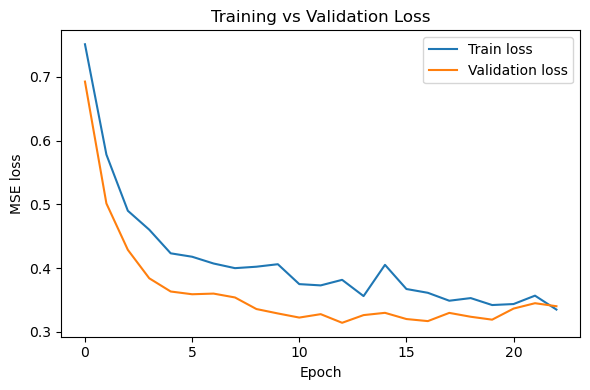

In [17]:
plt.figure(figsize=(6,4))
plt.plot(train_losses_hist, label='Train loss')
plt.plot(val_losses_hist, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('MSE loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.tight_layout()
plt.show()